# Определение закономерности успешности игры.


**Описание проекта**:   <br>
Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).<br>
<br>
Имеем данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.<br>
<br>
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Цель проекта:** выявить определяющие успешность игры закономерности, чтобы в будущем можно было определять перспективные направления развития, составлять рекламные кампании и так далее.

## Шаг: Загрузка данных

In [1]:
# Загрузим необходимые библиотеки и параметры вывода
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [2]:
try:
    try:
        data = pd.read_csv(r'C:/games.csv') #домашняя версия
    except:
        data = pd.read_csv('/datasets/games.csv') #сетевая версия
    
except:
    print('Не удалось прочесть файл. Возможно, был указан не верный путь.')

### Описание данных

In [3]:
display(data.sample(5))
data.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
5681,Lord of Arcana,PSP,2010.0,Role-Playing,0.07,0.04,0.17,0.03,53.0,5.5,M
10389,Kuroko's Basketball: Miracle Game,PSP,2012.0,Sports,0.00,0.00,0.11,0.00,NaN,NaN,NaN
775,Dance Dance Revolution Extreme,PS2,2004.0,Simulation,1.04,0.81,0.00,0.27,77.0,9,E
246,God of War,PS2,2005.0,Action,2.71,1.29,0.02,0.43,94.0,8.9,M
2062,1942,NES,1985.0,Shooter,0.65,0.14,0.21,0.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


`Name` — название игры<br>
`Platform` — платформа<br>
`Year_of_Release` — год выпуска<br>
`Genre` — жанр игры<br>
`NA_sales` — продажи в Северной Америке (миллионы долларов)<br>
`EU_sales` — продажи в Европе (миллионы долларов)<br>
`JP_sales` — продажи в Японии (миллионы долларов)<br>
`Other_sales` — продажи в других странах (миллионы долларов)<br>
`Critic_Score` — оценка критиков (от 0 до 100)<br>
`User_Score` — оценка пользователей (от 0 до 10)<br>
`Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board)<br>

Всего 16715 строк и 11 колонок. Видно, что присутсвуют пропуски, колонки указаны в "верблюжем" стиле. Так же типы у некоторых колонок не соответствуют описанию и наполнению. Устраним недочеты.

## Предобработка данных
  
### Стиль записи
Первым делом приведем название столбцов к нижнему регистру.

In [4]:
data.columns = map(str.lower, data.columns)

In [5]:
data.columns.tolist()

['name',
 'platform',
 'year_of_release',
 'genre',
 'na_sales',
 'eu_sales',
 'jp_sales',
 'other_sales',
 'critic_score',
 'user_score',
 'rating']

### Пропуски
проверим данные на пропуски

In [6]:
# вывод пропусков в %, отсорированные по убыванию.
round(data.isna().mean().sort_values(ascending=False)*100,2)

critic_score       51.32
rating             40.48
user_score         40.09
year_of_release     1.61
name                0.01
genre               0.01
platform            0.00
na_sales            0.00
eu_sales            0.00
jp_sales            0.00
other_sales         0.00
dtype: float64

In [7]:
display(data.loc[data['genre'].isna()==True].head(10)) 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [8]:
display(data.loc[data['name'].isna()==True].head(10)) 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Технически заменить пропуски не представляется возможным из за отсутсвия информации.

In [9]:
display(data.loc[data['year_of_release'].isna()==True].head(5))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


In [10]:
# удаляем строки с пустыми значениями в колонке name и year_of_release.
data = data.dropna(subset=['name', 'year_of_release'])

In [11]:
# обновляем индексы
data = data.reset_index(drop=True)

In [12]:
# повторно проверим на наличие пропусков
round(data.isna().mean().sort_values(ascending=False)*100,2)

critic_score       51.45
rating             40.60
user_score         40.17
name                0.00
platform            0.00
year_of_release     0.00
genre               0.00
na_sales            0.00
eu_sales            0.00
jp_sales            0.00
other_sales         0.00
dtype: float64

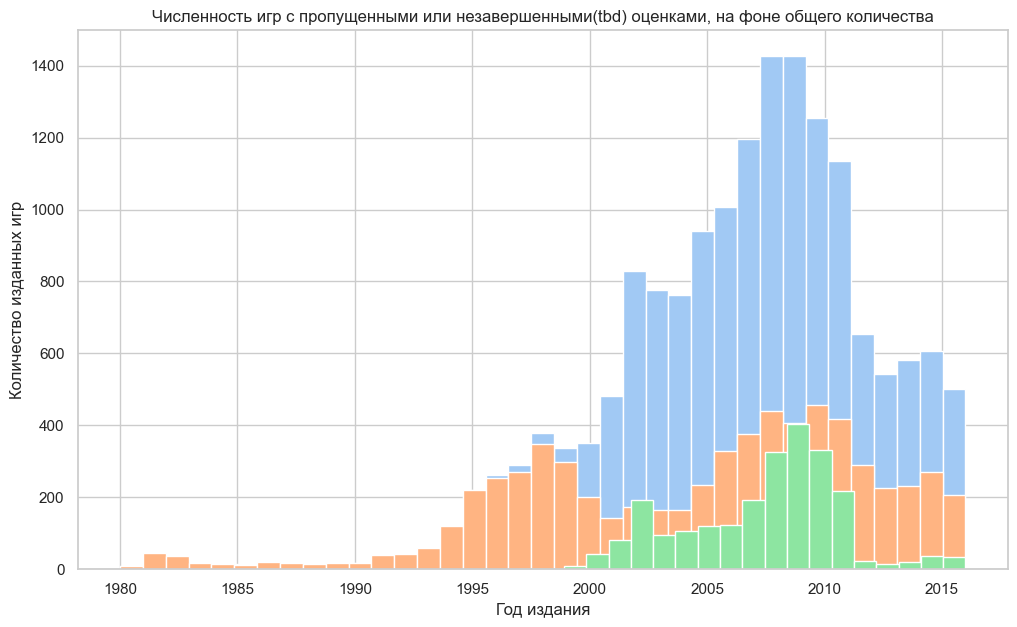

In [13]:
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(12, 7))

data['year_of_release'].hist(bins=37)
data.loc[data['user_score'].isna(), 'year_of_release'].hist(bins=37)
data.loc[data['user_score']=='tbd', 'year_of_release'].hist(bins=20)


plt.title('Численность игр с пропущенными или незавершенными(tbd) оценками, на фоне общего количества')
plt.ylabel('Количество изданных игр')
plt.xlabel('Год издания');

In [14]:
display(data.loc[data['rating'].isna()==True].head(5)) 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


Согласно рейтингу ESRB существуют рейтинги:
«EC» («Early childhood») — «Для детей младшего возраста»
«E» («Everyone») — «Для всех»
«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
«T» («Teen») — «Подросткам»
«M» («Mature») — «17+»
«AO» («Adults Only 18+») — «Только для взрослых»
«RP» («Rating Pending») — «Рейтинг ожидается»

Пропуски скорее всего говорят о том, что не были присвоены рейтинги.
Следовательно пустые значения можно отвести к рейтингу RP - еще не присвоен окончательный рейтинг.
Категория К-А в 1998 была переименована в «E».

In [15]:
data['rating'] = data['rating'].fillna('RP')
data.loc[data['rating'].isin(['K-A']), 'rating'] = 'E'
data.rating.value_counts()

RP      6677
E       3924
T       2905
M       1536
E10+    1393
EC         8
AO         1
Name: rating, dtype: int64

Пропуски в critic_score и user_score исключить не целесообразно. Оставим их без изменения.

### Дубликаты и Аномалии

Рассмотрим неявные дубликаты

In [16]:
data['critic_score'].sort_values().unique()

array([13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
       96., 97., 98., nan])

In [17]:
data['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

In [18]:
data['user_score'][data['user_score']== 'tbd'].count()

2376

В этом столбце встречается значение tbd 2376 раз. TBD — это аббревиатура, которая обозначает «To Be Determined» (англ. «будет определено»). Это выражение означает, что некоторые детали еще не определены. Удаление данных строк будет уже критичным, по этому заменим его на "nаn".

In [19]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

In [20]:
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [29]:
data['name'].sort_values().unique()

array([' Beyblade Burst', ' Fire Emblem Fates', " Frozen: Olaf's Quest",
       ..., 'uDraw Studio', 'uDraw Studio: Instant Artist',
       '¡Shin Chan Flipa en colores!'], dtype=object)

In [30]:
# удаление пропусков в названии.
data['name'] = data['name'].str.strip()
# приведение название к однотипности
data['name'] = data['name'].replace('007 Racing', '007: Racing')

In [31]:
data['critic_score'].sort_values().unique()  

array([13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
       96., 97., 98., nan])

In [32]:
data['platform'].sort_values().unique()             

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

In [33]:
data.duplicated().sum()

0

In [34]:
data[['name', 'platform','year_of_release']].duplicated().sum()

1

In [36]:
# Посмотрим наглядно на данные дубликаты
data[['name', 'platform','year_of_release']].value_counts().head(10)

name                     platform  year_of_release
Madden NFL 13            PS3       2012.0             2
'98 Koshien              PS        1998.0             1
Ratatouille              PS2       2007.0             1
Rapala Trophies          PSP       2006.0             1
Rapala for Kinect        X360      2011.0             1
Rapala's Fishing Frenzy  Wii       2008.0             1
Rapala: We Fish          Wii       2009.0             1
Rapid Reload             PS        1995.0             1
Rare Replay              XOne      2015.0             1
Rascal                   PS        1998.0             1
dtype: int64

In [37]:
data.query('name in ["Madden NFL 13"]').sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
503,Madden NFL 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
600,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3933,Madden NFL 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5800,Madden NFL 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
6956,Madden NFL 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
15969,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [38]:
# исключаем дубликат
data = data.drop(index=[15969])

In [39]:
data[['name', 'platform','year_of_release']].duplicated().sum()

0

Дубликаты отсутствуют.  
  
Рассмотрим аномалии.

In [40]:
#у платформы DS обнаружены выбросы - 1985 год. Рассмотрим данные DS
data[(data['year_of_release'] == 1985) & (data['platform']=='DS')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15704,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,RP


Можно предположить, что "Strongest Tokyo University Shogi" - какая-то компьютерная игра в сёги которая разрабатывалась в Токийском Университете, при этом никакого отношения к платформе Nintendo DS она не имеет, потому что в 1985 году этой платформы еще не было.   
Т.к. строка содержит ошибочные данные удалим ее.

In [41]:
data = data.drop(index=[15818])

### Тип данных
Просмотрим типы данных:  
year_of_release установим int;  
critic_score и user_score - float;  

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16442 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16442 non-null  object 
 1   platform         16442 non-null  object 
 2   year_of_release  16442 non-null  float64
 3   genre            16442 non-null  object 
 4   na_sales         16442 non-null  float64
 5   eu_sales         16442 non-null  float64
 6   jp_sales         16442 non-null  float64
 7   other_sales      16442 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   object 
 10  rating           16442 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [43]:
# оставим тип int для даты.
data['year_of_release']= data['year_of_release'].astype('int')

In [44]:
data['user_score']=data['user_score'].astype('float64')

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16442 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16442 non-null  object 
 1   platform         16442 non-null  object 
 2   year_of_release  16442 non-null  int32  
 3   genre            16442 non-null  object 
 4   na_sales         16442 non-null  float64
 5   eu_sales         16442 non-null  float64
 6   jp_sales         16442 non-null  float64
 7   other_sales      16442 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16442 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


### Суммарные продажи
Суммарные продажи во всех регионах в отдельном столбце.

In [46]:
data['sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
display(data.sample(5))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
15059,Kannou Mukashi Banashi Portable,PSP,2012,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,RP,0.02
15119,Atari Flashback Classics: Volume 1,XOne,2016,Misc,0.02,0.00,0.00,0.00,NaN,NaN,E,0.02
13165,Ship Simulator Extremes,PC,2010,Simulation,0.00,0.04,0.00,0.01,49.0,6.2,E,0.05
5186,SOCOM: Tactical Strike,PSP,2007,Shooter,0.32,0.01,0.00,0.03,NaN,NaN,RP,0.36
14885,TV Total Events,Wii,2011,Misc,0.00,0.02,0.00,0.00,NaN,NaN,RP,0.02


**Вывод:**  
Привели названия колонок в нижнему регистру.  
Обработали пропуски и проверили данные на дубликаты.  
Исключили аномальные значения.  
Привели данные к правильному типу.  
Добавлен столбец с общей суммой продаж.

## Исследовательский анализ данных
  


In [47]:
# Сперва узнаем минимальную и максимальную дату.
print('Первый год выпуска игры -', data['year_of_release'].min())
print('Последний год выпуска игры -',data['year_of_release'].max())

Первый год выпуска игры - 1980
Последний год выпуска игры - 2016


### График количества игр, которые выпускались в разные годa.

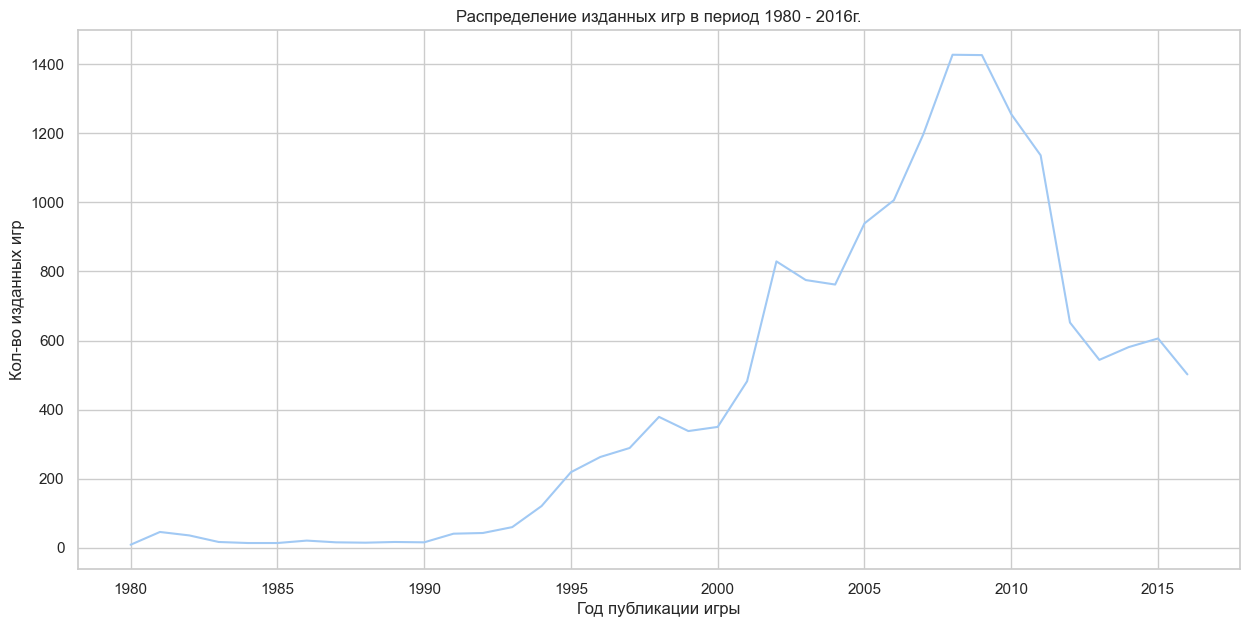

In [48]:
games_per_year = data.groupby('year_of_release')['name'].count().to_frame().reset_index()
games_per_year.plot(x='year_of_release', y='name', grid=True, legend=False, figsize=(15,7),
                    title='Распределение изданных игр в период 1980 - 2016г.',
                    xlabel='Год публикации игры', ylabel='Кол-во изданных игр');

На графике видно, как в 2000 году прошел резкий скачек издайний игр и в 2009 начинается спад.
Посмотрим подробнее два периода: с 1980 по 2000 и с 2000 по 2015.

In [55]:
data.query('year_of_release <= 2000') \
    .groupby(['year_of_release','platform'])['name'].count()

year_of_release  platform
1980             2600          9
1981             2600         46
1982             2600         36
1983             2600         11
                 NES           6
1984             2600          1
                 NES          13
1985             2600          1
                 DS            1
                 NES          11
                 PC            1
1986             2600          2
                 NES          19
1987             2600          6
                 NES          10
1988             2600          2
                 GB            1
                 NES          11
                 PC            1
1989             2600          2
                 GB           10
                 NES           5
1990             GB            3
                 GEN           1
                 NES           8
                 SNES          4
1991             GB            9
                 GEN           1
                 NES           7
                 

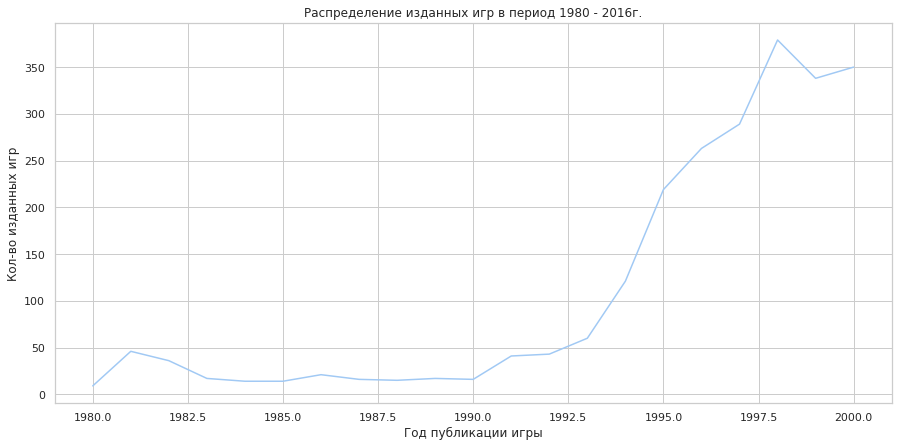

In [41]:
games_per_year.query('year_of_release <= 2000') \
              .plot(x='year_of_release', y='name', grid=True, legend=False, figsize=(15,7),
                    title='Распределение изданных игр в период 1980 - 2016г.',
                    xlabel='Год публикации игры', ylabel='Кол-во изданных игр');

На графике видно, как число создаваемых игр в 1981 году почти приблизилось к 50.  
С 1990 года график стремительно начал расти и к 1998 году число изданных игр превысило 375шт. Это обусловленно появлением на рынке таких консолей, как PS, SAT и SNES. В 1995 году изданы 99 игры для PS, 52 к SAT и 54 игры к SNES.  
К 2000 году число игр сократилось до 350. Наблюдается застой игровой индустрии с 1982 по 1990 года( график держался в районе 15 игр).  

*Появление новых игровых консолей влечет за собой спрос на новые игры и перенос старых игр на новую консоль с улучшенной графикой или продолжением серий.*

In [42]:
data.query('year_of_release >= 2000') \
    .groupby(['year_of_release','platform'])['name'].count()

year_of_release  platform
2000             DC           20
                 GB           17
                 GBA           1
                 N64          60
                 PC            7
                 PS          160
                 PS2          82
                 WS            2
                 XB            1
2001             DC            8
                 GB           10
                 GBA         107
                 GC           22
                 N64           9
                 PC           15
                 PS           91
                 PS2         185
                 WS            2
                 XB           33
2002             DC            1
                 GBA         198
                 GC          152
                 N64           1
                 PC           19
                 PS           20
                 PS2         280
                 XB          158
2003             GBA         150
                 GC          144
                 

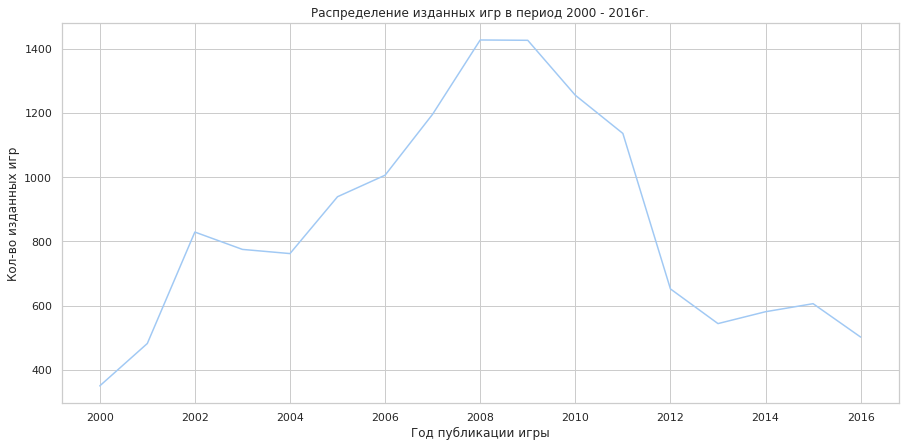

In [43]:
games_per_year.query('year_of_release >= 2000') \
              .plot(x='year_of_release', y='name', grid=True, legend=False, figsize=(15,7),
                    title='Распределение изданных игр в период 2000 - 2016г.',
                    xlabel='Год публикации игры', ylabel='Кол-во изданных игр');

На данном графике видны  
- 2 роста: 
    Начиная с 2000 года достигнув отметку в 810 шт в 2002 году. Это обусловлено появлением на рынке такой игровой консоли, как Nintendo DS, Wii и PS2.  
    Рост с 2004 пересек отметку в 1400 шт в 2008году.
- 1 падение: начиная с 2009 года падение до 550 шт в 2013году. Возможно это обусловлено с появлением новых технологий в развитии консолей и сложностью разработки игр нового поколения.  
  
**Вывод:** Рассмотрев укрупненно было понятно, что период до 1990 года показал себя стабильным и не имеет влияния на общую картину всего рассмотренного периода.

### График продажи игр по платформам

Рассмотрим график продаж игр по платформам.

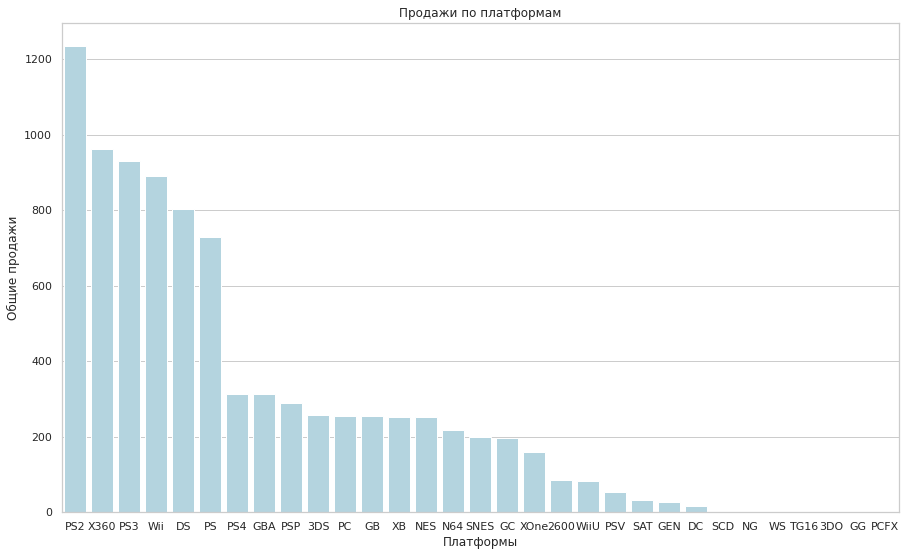

In [44]:
top_platforms = data.pivot_table(index='platform', values='sales', aggfunc='sum') \
                    .sort_values('sales', ascending=False)

plt.figure(figsize=(15, 9))
(sns.barplot(data = top_platforms, x = top_platforms.index, y = 'sales', color='lightblue')
    .set(title = 'Продажи по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи'))
plt.show()

In [45]:
top_platforms

,sales
platform,
PS2,1233.54
X360,961.24
PS3,931.33
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


За весь период больше всего продаж было у PS2 (1233.56 млн. долларов.). Хуже всех продавались игры на PCFX - всего 30 000 долларов. (провальная консоль от NES).  

Платформы можно разделить на 3 группы: 
1. *Приоритетные консоли*. В них входят PS2, Xbox360, PS3, Wii,DS,PS
2. *Средние консоли*. В них входят PS4, GBA, PSP, 3DS, PC, GB, XB, NES, N64, SNES, GC и XboxOne
3. *Невостребованные консоли*. В них входят 2600, WiiU, PSV, SAT, GEN, DC, SegaCD, NG и остальные...

Успешность PS2 обусловлено отсутствием явных конкурентов при появлении консоли от Sony. Пользователи того времени охотно покупали игры "нового поколения". Со временем Microsoft выпустил консоль Xbox360, которая стала конкурировать уже с PS3 и Wii.  
  
Рассмотрим продажи игр по годам для каждой консоли из первой группы.

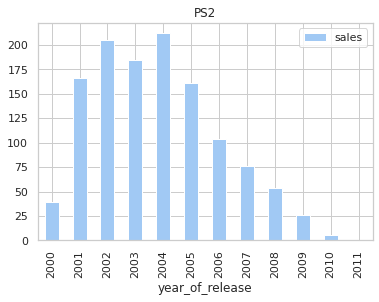

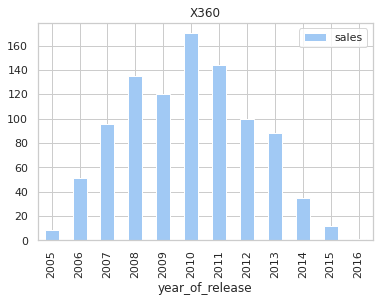

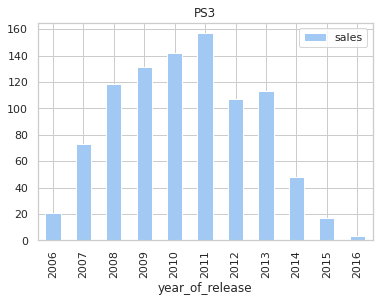

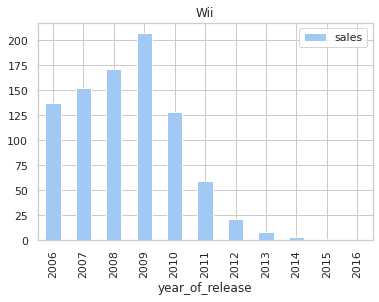

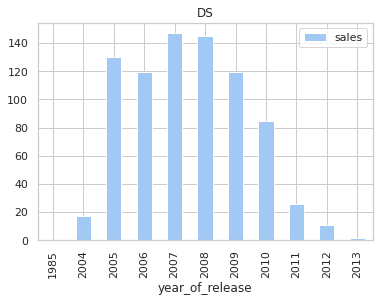

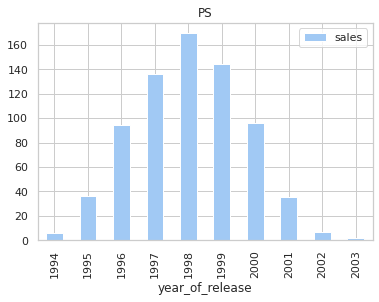

In [46]:
for i in top_platforms.index[:6]:
    (data.query('platform == @i')
         .pivot_table(index='year_of_release', values='sales', aggfunc='sum')
         .plot(kind='bar'))
    plt.title(i)

В топ 6 конкурентов среди продаж вошли:
- PS2 - PlayStation 2 (успешен в 2001-2005 годах)
- X360 - Xbox360 (успешен в 2008-2011 годах)
- PS3 - PlayStation 3 (успешен в 2008-2011 годах)
- Wii - NintendoWii  (успешен в 2006-2009 годах)
- DS - Nintendo DS (успешен в 2007-2009 годах)
- PS - PlayStation 1 (успешен в 1997-1999 годах)

Из этого можно сделать вывод, что пик продаж игр на консолях составляет 3 года.

In [47]:
# Рассмотрим продолжительность жизни консолей.
# для формирования таблицы исключим невостребованные и новые консоли, а так же PC из-за возможности модернизации оборудования всегда будет актыальным.
lt = data.query('platform in ["DS", "GBA", "GC", "N64", "PS2", "PSP", "Wii", "XB"]')

# функция расчета среднего времени
def mean_living_time (data):
    min_lt = data.groupby('platform')['year_of_release'].min().reset_index()
    div_t = (data.groupby('platform')['year_of_release'].max() - data.groupby('platform')['year_of_release'].min()).reset_index()
    living_time = min_lt.merge(div_t, on= 'platform').set_index('platform')
    living_time.columns = ['min_year', 'div_year']
    print(living_time.sort_values(by = 'min_year'))
    print("Среднее время актуальности игровой платформы: {} лет".format(round(living_time['div_year'].mean())))
    
mean_living_time(lt)

          min_year  div_year
platform                    
DS            1985        28
N64           1996         6
GBA           2000         7
PS2           2000        11
XB            2000         8
GC            2001         6
PSP           2004        11
Wii           2006        10
Среднее время актуальности игровой платформы: 11 лет


Построим графики по производителям консолей.

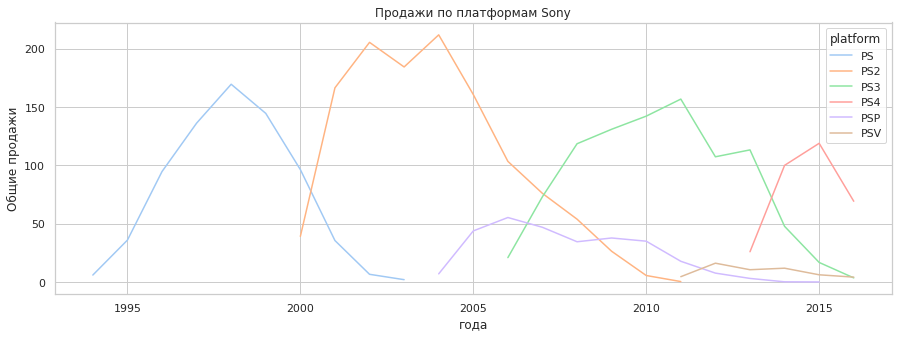

In [48]:
# Sony
sony = ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV']

sales_sony = data.query('platform in @sony').groupby(['platform', 'year_of_release'])[['sales']].sum().reset_index()
plt.figure(figsize=(15, 5))

(sns.lineplot(x='year_of_release',y='sales', hue='platform', data=sales_sony.reset_index())
   .set(title = 'Продажи по платформам Sony', xlabel = 'года', ylabel = 'Общие продажи'));

In [49]:
mean_living_time(sales_sony)

          min_year  div_year
platform                    
PS            1994         9
PS2           2000        11
PSP           2004        11
PS3           2006        10
PSV           2011         5
PS4           2013         3
Среднее время актуальности игровой платформы: 8 лет


Разница в годах между выходом новой консоли составляет в среднем 7 лет

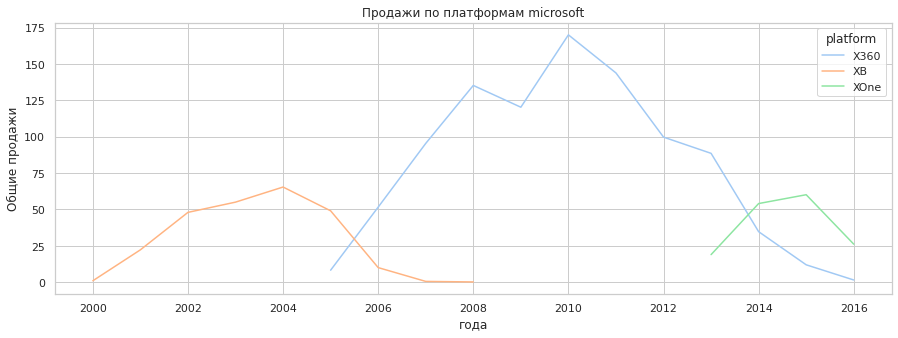

In [50]:
# Microsoft
microsoft = ['XB', 'X360', 'XOne']

sales_x = data.query('platform in @microsoft').groupby(['platform', 'year_of_release'])[['sales']].sum().reset_index()
plt.figure(figsize=(15, 5))

(sns.lineplot(x='year_of_release',y='sales', hue='platform', data=sales_x.reset_index())
   .set(title = 'Продажи по платформам microsoft', xlabel = 'года', ylabel = 'Общие продажи'));

In [51]:
mean_living_time(sales_x)

          min_year  div_year
platform                    
XB            2000         8
X360          2005        11
XOne          2013         3
Среднее время актуальности игровой платформы: 7 лет


Разница в годах между выходом новой консоли составляет в среднем 7 лет

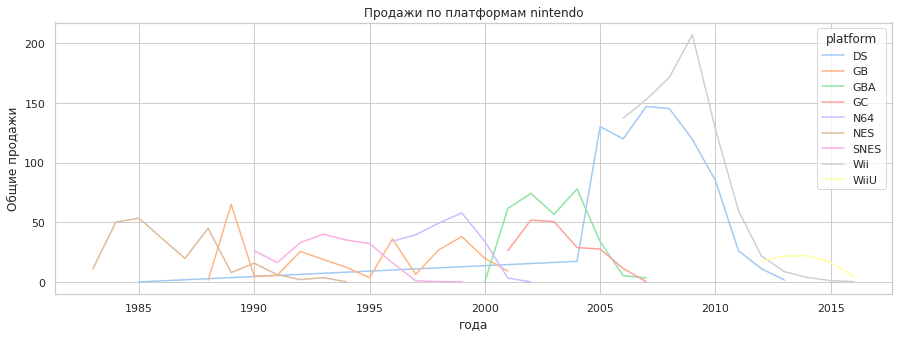

In [52]:
# Nintendo
nintendo = ['DS', 'GB', 'GBA', 'GC', 'N64', 'NES', 'SNES','Wii', 'WiiU']

sales_n = data.query('platform in @nintendo').groupby(['platform', 'year_of_release'])[['sales']].sum().reset_index()
plt.figure(figsize=(15, 5))

(sns.lineplot(x='year_of_release',y='sales', hue='platform', data=sales_n.reset_index())
   .set(title = 'Продажи по платформам nintendo', xlabel = 'года', ylabel = 'Общие продажи'));

In [53]:
mean_living_time(sales_n)

          min_year  div_year
platform                    
NES           1983        11
DS            1985        28
GB            1988        13
SNES          1990         9
N64           1996         6
GBA           2000         7
GC            2001         6
Wii           2006        10
WiiU          2012         4
Среднее время актуальности игровой платформы: 10 лет


Разница в годах между выходом новой консоли составляет в среднем 7 лет

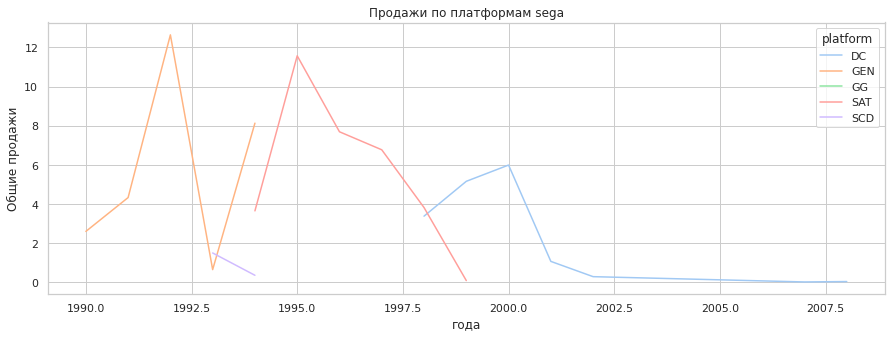

In [54]:
# Sega
sega = ['DC', 'GEN', 'GG', 'SAT', 'SCD']

sales_sega = data.query('platform in @sega').groupby(['platform', 'year_of_release'])[['sales']].sum().reset_index()
plt.figure(figsize=(15, 5))

(sns.lineplot(x='year_of_release',y='sales', hue='platform', data=sales_sega.reset_index())
   .set(title = 'Продажи по платформам sega', xlabel = 'года', ylabel = 'Общие продажи'));

In [55]:
mean_living_time(sales_sega)

          min_year  div_year
platform                    
GEN           1990         4
GG            1992         0
SCD           1993         1
SAT           1994         5
DC            1998        10
Среднее время актуальности игровой платформы: 4 лет


Разница в годах между выходом новой консоли составляет в среднем 3 года.

### Исследование Актуального периода 
Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Актуальными данными будем считать с 2013 года. Обусловлен выбор появлением нового поколения консолей. Так же согласно графику "Распределение изданных игр в период 1980 - 2016г." появляется новый подьем игровой индустрии. Следовательно, нам надо оставить все, что было после 2012.

In [56]:
actual_data = data[data['year_of_release'] > 2012]
actual_data.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
14373,Darius Burst: Chronicle Saviours,PSV,2016,Action,0.00,0.00,0.03,0.0,NaN,NaN,RP,0.03
7255,Dragon Ball: Fusions,3DS,2016,Role-Playing,0.02,0.00,0.19,0.0,68.0,7.6,T,0.21
6838,Girls Mode 3: Kirakira Code,3DS,2015,Action,0.00,0.00,0.23,0.0,NaN,NaN,RP,0.23
14310,Rugby 15,X360,2015,Sports,0.00,0.03,0.00,0.0,NaN,NaN,E,0.03
15477,Prince of Stride,PSV,2015,Adventure,0.00,0.00,0.02,0.0,NaN,NaN,RP,0.02


### Какие платформы лидируют по продажам, растут или падают?

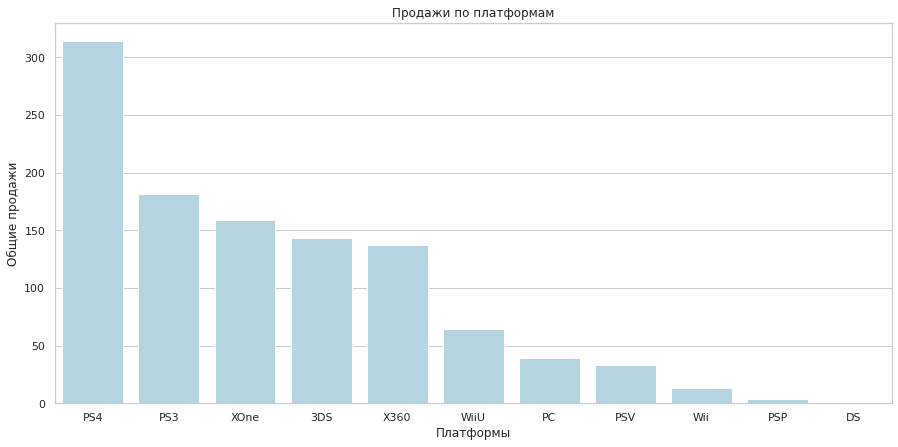

In [57]:
top_platforms = actual_data.pivot_table(index='platform', values='sales', aggfunc='sum') \
                    .sort_values('sales', ascending=False)

plt.figure(figsize=(15, 7))
(sns.barplot(data = top_platforms, x = top_platforms.index, y = 'sales', color='lightblue')
    .set(title = 'Продажи по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи'))
plt.show()

Самые лучшие продажи у PS4 и XboxOne. Хуже всех у Wii и PSP.  
На тепловой матрице рассмотрим подроблее по годам.

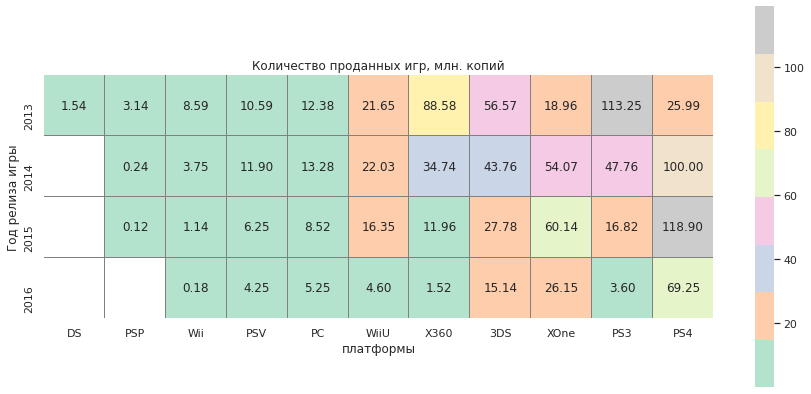

In [58]:
sales_years = actual_data.pivot_table(index='year_of_release',
                                                    columns='platform',
                                                    values='sales',
                                                    aggfunc='sum')

#Изменить порядок столбцов, для визуального упрощения
sales_years = sales_years.reindex(columns = actual_data.groupby('platform')\
    ['sales'].sum().sort_values().to_frame().reset_index()['platform'].unique())

plt.figure(figsize=(15, 7))
sns.heatmap(sales_years, square=True, annot=True, fmt=".2f", linewidth=.01, linecolor='grey',cmap= 'Pastel2')
plt.title('Количество проданных игр, млн. копий')
plt.xlabel('платформы')
plt.ylabel('Год релиза игры');

По годам видно, как PS4 и XboxOne с каждым годом увеличивала обьемы продаж. Они и будут являться потенциально прибыльными. 
Так же можно отнести к ним 3DS, виден спад, но не критичный, как у остальных.
PC является стабильной игровой платформой, можно 
Так же видно, что в 2016 году у всех идет падение обьемов. Вероятнее всего это связано с неполноценными данными за 2016 год.

### График «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

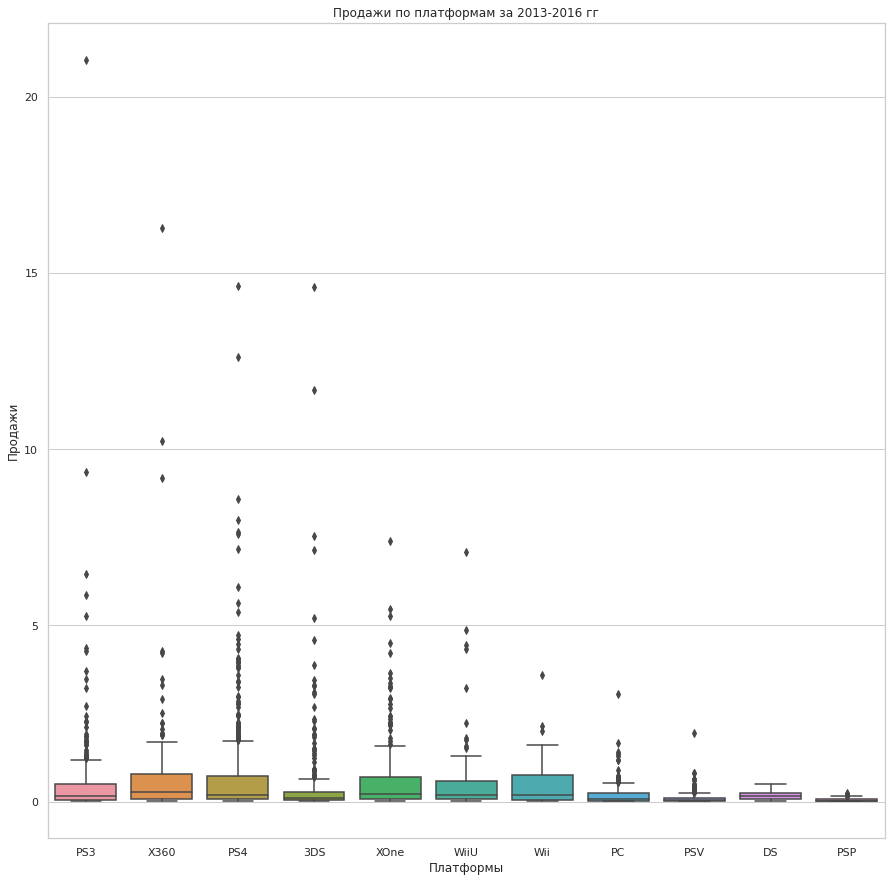

In [59]:
plt.figure(figsize=(15, 15))
(sns.boxplot(data = actual_data, y = 'sales', x='platform')
    .set(title = 'Продажи по платформам за 2013-2016 гг', 
         xlabel = 'Платформы', 
         ylabel = 'Продажи'))
plt.show()

Рассмотрим подробнее с лимитом по продажам в 2млн.

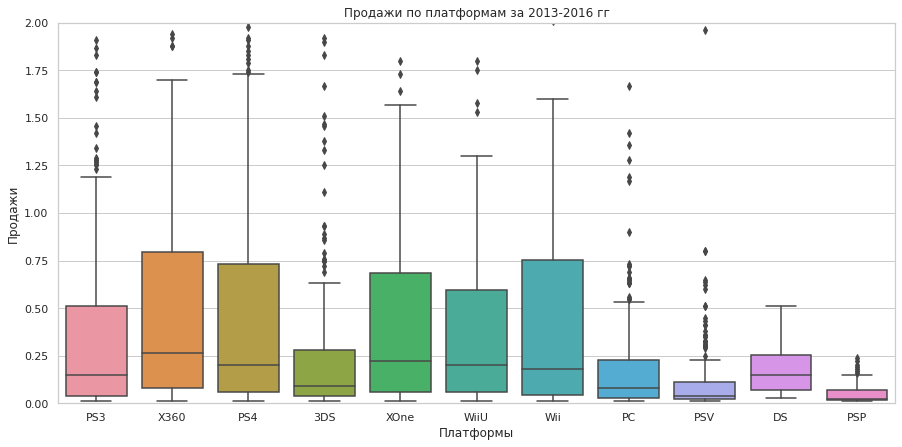

In [60]:
plt.figure(figsize=(15, 7))
(sns.boxplot(data = actual_data, y = 'sales', x='platform')
    .set(title = 'Продажи по платформам за 2013-2016 гг', 
         xlabel = 'Платформы', 
         ylabel = 'Продажи',
         ylim=(0, 2)))
plt.show()

За пределами 3-ого квартиля присутствуют выбросы - они же бесцеллеры игровой индустрии. Эти игры расположены в диапазоне от 2-25 млн. продаж.

Медийные значения расположены в районе 0,2 млн.  
Первые 4 платформы слева - лидеры, которые выбиваются в топ именно за счёт своих бестселлеров. На них так же стоит обратить внимание.

### Влияние на продажи внутри одной популярной платформы.

In [61]:
# сформируем отдельно функцию для построения графиков на каждую из платформ и рассчет корреляции.
def hexbin_platforms (name):
    platforms_corr = actual_data[(actual_data['platform'] == name)][['sales','critic_score','user_score']]
    plt.subplots(figsize=(15, 5))
    
    # plot one
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='critic_score', y='sales', data=platforms_corr)
    plt.title(f'Влияние отзывов критиков на продажи платформы {name}')
    plt.xlabel('отзывы критиков')
    plt.ylabel('количетсво продаж')
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='user_score', y='sales', data=platforms_corr)
    plt.title(f'Влияние отзывов пользователей на продажи платформы{name}')
    plt.xlabel('отзывы пользователей')
    plt.ylabel('количетсво продаж')

    plt.tight_layout(4)
    plt.show();
    
    print(platforms_corr.corr())

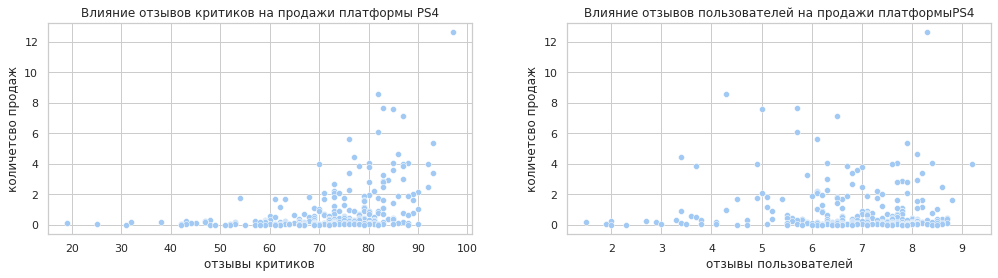

                 sales  critic_score  user_score
sales         1.000000      0.406568   -0.031957
critic_score  0.406568      1.000000    0.557654
user_score   -0.031957      0.557654    1.000000


In [62]:
hexbin_platforms('PS4')

Большая часть отзывов критиков располагаются в диапазоне 50-90, у пользователей - 5,5-8,8.  
Продажи в основном не превышают 2млн.
  
Влияние оценок критиков положительно вляют на продажи, но зависимость слабая, около 40%.  
Пользовательские оценки не влияют на продажи совсем.

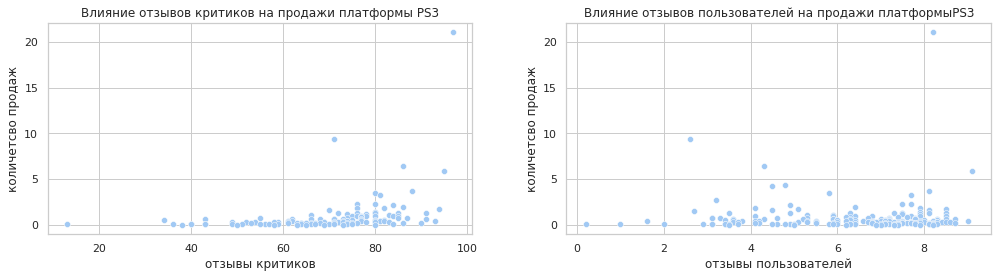

                 sales  critic_score  user_score
sales         1.000000      0.334285    0.002394
critic_score  0.334285      1.000000    0.599920
user_score    0.002394      0.599920    1.000000


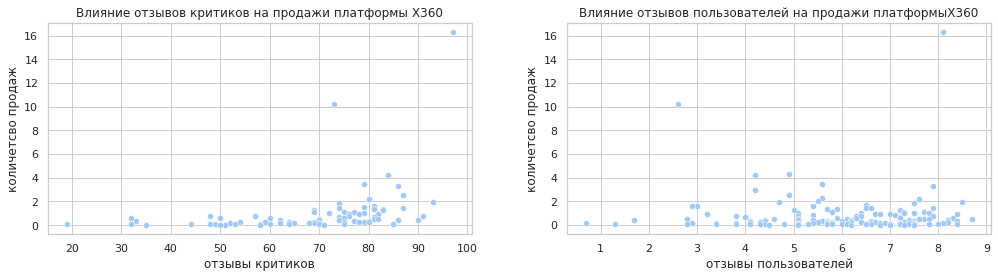

                 sales  critic_score  user_score
sales         1.000000      0.350345   -0.011742
critic_score  0.350345      1.000000    0.520946
user_score   -0.011742      0.520946    1.000000


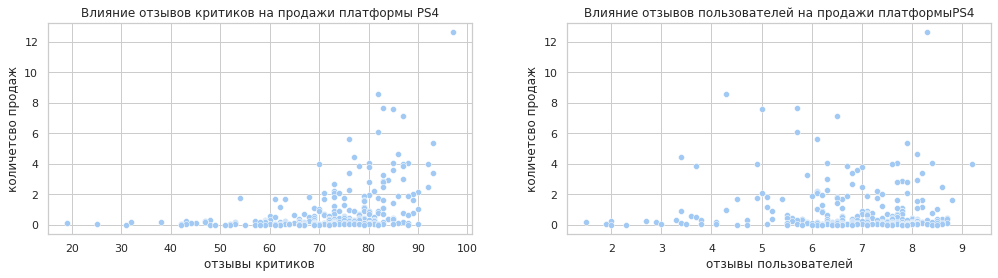

                 sales  critic_score  user_score
sales         1.000000      0.406568   -0.031957
critic_score  0.406568      1.000000    0.557654
user_score   -0.031957      0.557654    1.000000


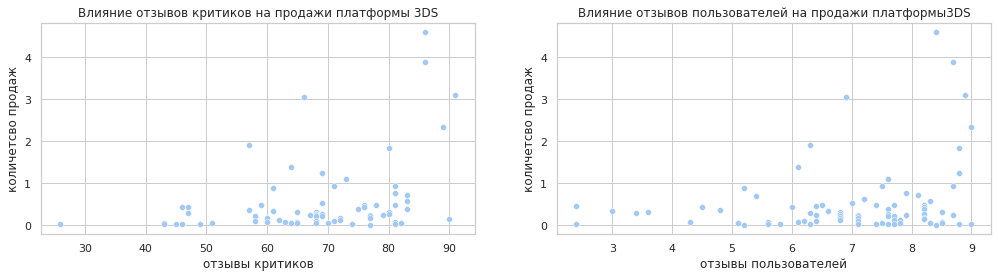

                 sales  critic_score  user_score
sales         1.000000      0.357057    0.241504
critic_score  0.357057      1.000000    0.769536
user_score    0.241504      0.769536    1.000000


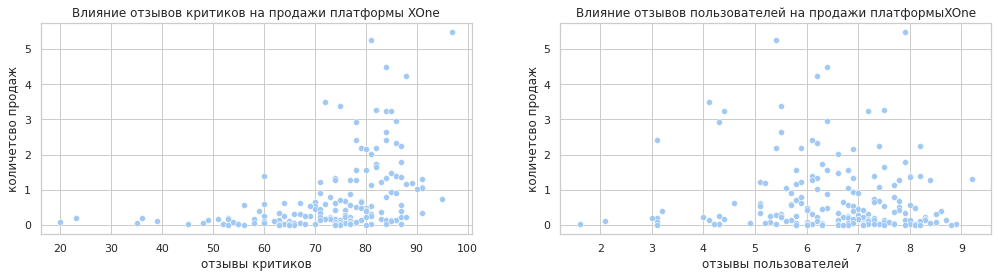

                 sales  critic_score  user_score
sales         1.000000      0.416998   -0.068925
critic_score  0.416998      1.000000    0.472462
user_score   -0.068925      0.472462    1.000000


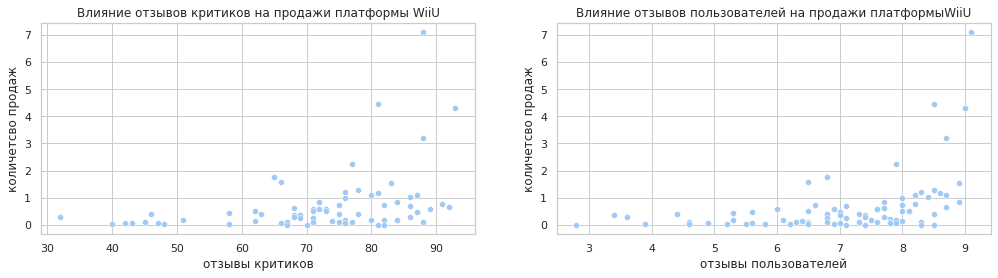

                 sales  critic_score  user_score
sales         1.000000      0.376415    0.419330
critic_score  0.376415      1.000000    0.721313
user_score    0.419330      0.721313    1.000000


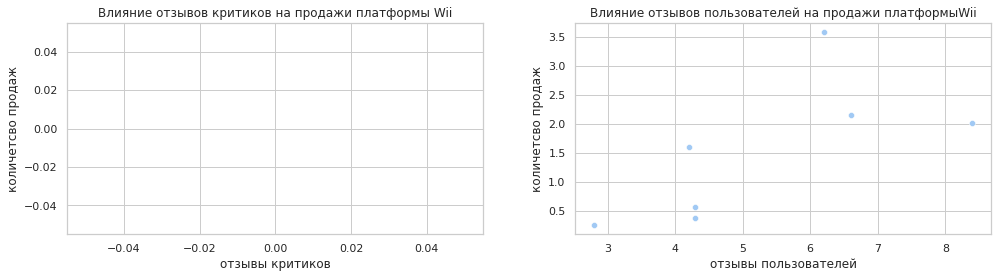

                 sales  critic_score  user_score
sales         1.000000           NaN    0.682942
critic_score       NaN           NaN         NaN
user_score    0.682942           NaN    1.000000


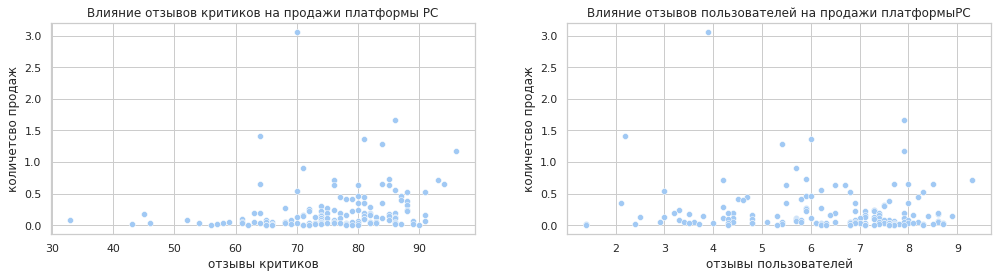

                 sales  critic_score  user_score
sales         1.000000      0.196030   -0.093842
critic_score  0.196030      1.000000    0.429562
user_score   -0.093842      0.429562    1.000000


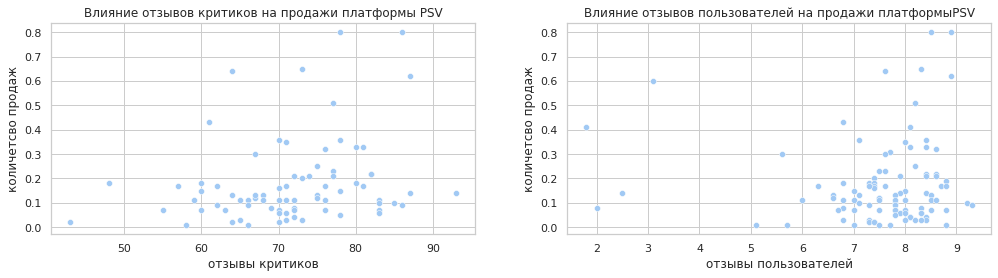

                 sales  critic_score  user_score
sales         1.000000      0.254742    0.000942
critic_score  0.254742      1.000000    0.611521
user_score    0.000942      0.611521    1.000000


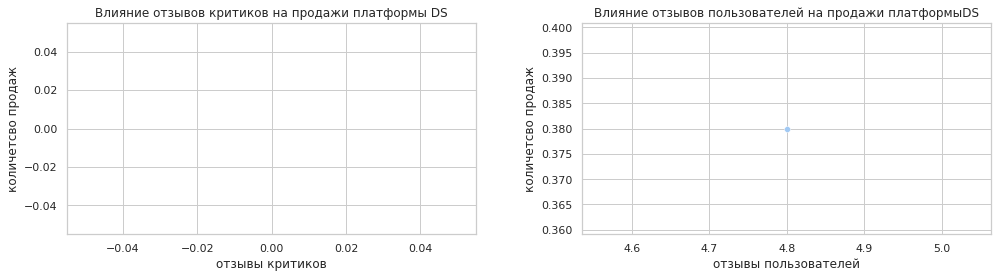

              sales  critic_score  user_score
sales           1.0           NaN         NaN
critic_score    NaN           NaN         NaN
user_score      NaN           NaN         NaN


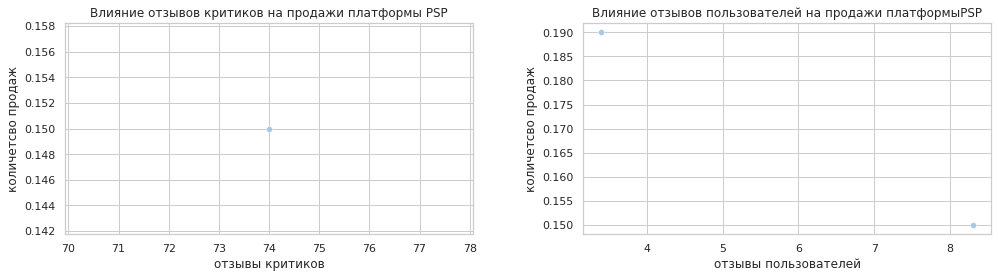

              sales  critic_score  user_score
sales           1.0           NaN        -1.0
critic_score    NaN           NaN         NaN
user_score     -1.0           NaN         1.0


In [63]:
ad = actual_data['platform'].unique()
for i in ad:
    hexbin_platforms(i)

Мнения критиков (critic_score) влияют на продажи сильнее, чем мнение пользователей (user_score).

Наибольшая явная зависимость у новых консолей Playstation 4 (0,4) и Xbox One (0.41), наименее явная у PC (0.20). 
Резкий рост продаж начинается с оценок критиков порядка 70-80 баллов.

Исходя из полученных результатов можно сделать вывод, что большая часть оценок критиков расположена в диапазоне (50 - 85), оценки пользователей (5,5 - 8,5). Продажи по большей части не превышают 2 млн. 

Особенность выявлена у 3DS. В основном оценки на платформах XOne, PS4 и PC отличаются незначительно, плотность оценок в основном парьируется в диапазоне, но на платформе 3DS средние оценки критиков немного ниже, чем на других платформах. На всех платформах, кроме 3DS, оценки критиков выше пользовательских.

### Соотнесите выводы с продажами игр на других платформах

Среди оценок игроков вовсе отсутствует явная зависимость. Коэф. корреляции принимает значения близкие к нулю. Но заметно, что на консолях предыдущего поколения Playstation 3 и Xbox 360 значительно меньше бестселлеров, за исключением новых игр, которые были адаптированы и для старых игровых приставок. То небольшое количество флагманских игр продолжают увеличивать миллионные продажи, и продлевают срок актуальности этих платформ. Самая малочисленная по числу продаж - PC, которая отличается в несколько раз.

### Посмотрите на общее распределение игр по жанрам. 

Целесообразнее всего построить боксплот, тем самым мы узнаем медианные значения и исключим выбросы, вызванные экслюзивами, популярными и хоитовыми играми.

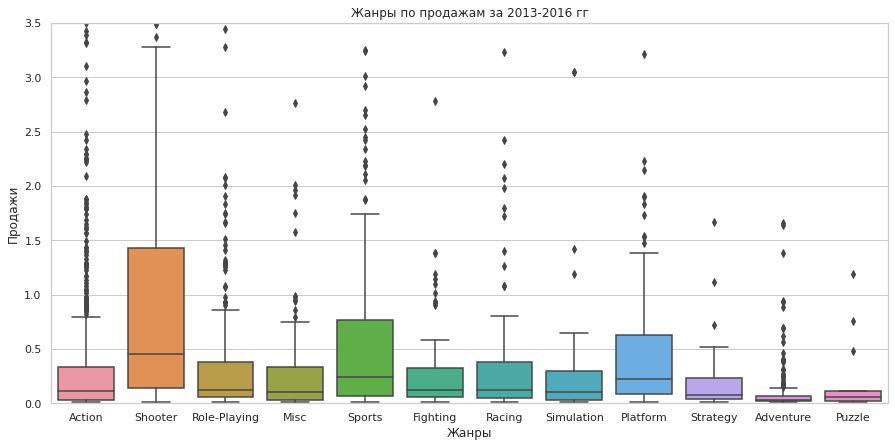

In [64]:
plt.figure(figsize=(15, 7))
(sns.boxplot(data = actual_data, y = 'sales', x='genre')
    .set(title = 'Жанры по продажам за 2013-2016 гг', 
         xlabel = 'Жанры', 
         ylabel = 'Продажи',
         ylim=(0, 3.5)))
plt.show()

Самые прибыльне: Shooter, Sports и Platform.  
Самые убыточные: Пазлы, Стратегии  и Приключения.

**Вывод:** 
- Самый пик продаж был в 2008 году. Далее с каждым годом шел спад до 2013
- Средний пик продаж платформы составлыяет 3 года.
- Мнение критиков сильнее влияют на продажи, чем мнение пользователей.
- Топ 3 жанра проданых игр за 2013-2016 - Shooter, Sports и Platform.

## Составьте портрет пользователя каждого региона

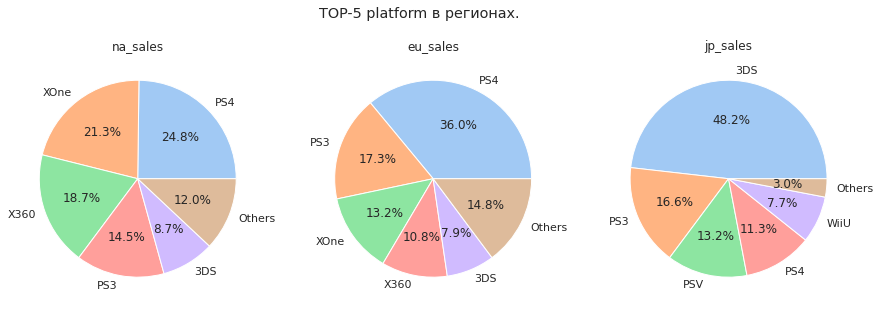

,platform_na,na_sales,part_na,platform_eu,eu_sales,part_eu,platform_jp,jp_sales,part_jp
pos,,,,,,,,,
1,PS4,108.74,24.8,PS4,141.09,36.0,3DS,67.81,48.2
2,XOne,93.12,21.3,PS3,67.81,17.3,PS3,23.35,16.6
3,X360,81.66,18.7,XOne,51.59,13.2,PSV,18.59,13.2
4,PS3,63.50,14.5,X360,42.52,10.8,PS4,15.96,11.3
5,3DS,38.20,8.7,3DS,30.96,7.9,WiiU,10.88,7.7
6,Others,52.49,12.0,Others,58.26,14.8,Others,4.19,3.0


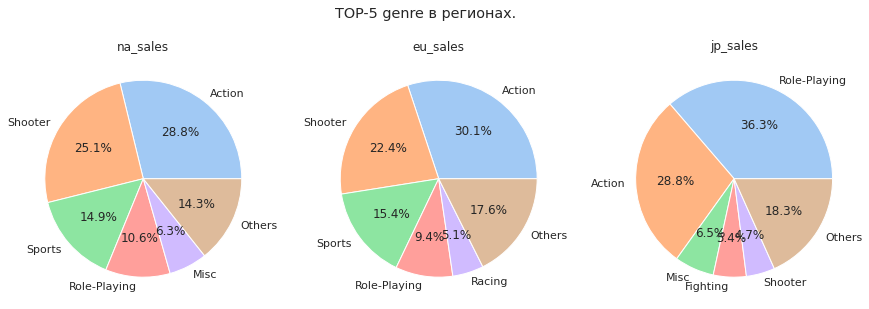

,genre_na,na_sales,part_na,genre_eu,eu_sales,part_eu,genre_jp,jp_sales,part_jp
pos,,,,,,,,,
1,Action,126.05,28.8,Action,118.13,30.1,Role-Playing,51.04,36.3
2,Shooter,109.74,25.1,Shooter,87.86,22.4,Action,40.49,28.8
3,Sports,65.27,14.9,Sports,60.52,15.4,Misc,9.20,6.5
4,Role-Playing,46.40,10.6,Role-Playing,36.97,9.4,Fighting,7.65,5.4
5,Misc,27.49,6.3,Racing,20.19,5.1,Shooter,6.61,4.7
6,Others,62.76,14.3,Others,68.56,17.6,Others,25.79,18.3


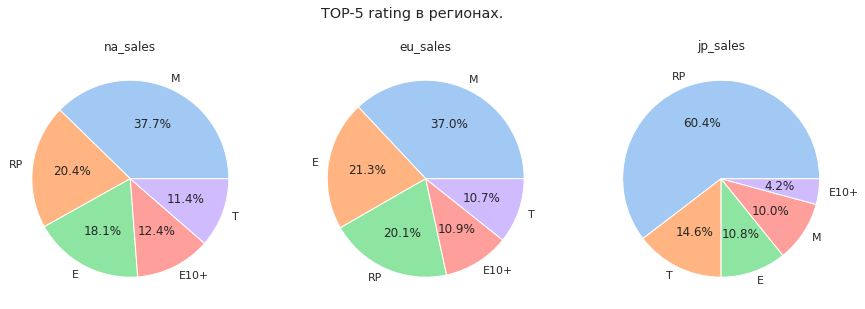

,rating_na,na_sales,part_na,rating_eu,eu_sales,part_eu,rating_jp,jp_sales,part_jp
pos,,,,,,,,,
1,M,165.21,37.7,M,145.32,37.0,RP,85.05,60.4
2,RP,89.42,20.4,E,83.36,21.3,T,20.59,14.6
3,E,79.05,18.1,RP,78.91,20.1,E,15.14,10.8
4,E10+,54.24,12.4,E10+,42.69,10.9,M,14.11,10.0
5,T,49.79,11.4,T,41.95,10.7,E10+,5.89,4.2


In [65]:
for col in ['platform', 'genre', 'rating']: #Критерии оценивания
    p_table = pd.DataFrame({'pos':[1, 2, 3, 4, 5, 6]}) # 'pos' - position
    fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # создание пространства для графиков: одна строка, три столбца.
    fig.suptitle('TOP-5 '+ col +' в регионах.')
    for sale, i in zip(['na_sales', 'eu_sales', 'jp_sales'], [0, 1, 2]): #Регионы оценивания
        top_5 = actual_data.groupby(col)[sale].sum().sort_values(ascending=False).to_frame().reset_index() 
        top_5['part'] = round(top_5[sale] / sum(top_5[sale]) * 100, 1)
        if col in ['platform', 'genre']:
            top_5.loc[5, col] = 'Others'
            top_5.loc[5, sale] = sum(top_5.loc[5:, sale])
            top_5.loc[5, 'part'] = 100 - sum(top_5.loc[0:4, 'part'])
            top_5 = top_5[:6]
        
        axs[i].pie(data=top_5, x='part', labels=col, autopct='%1.1f%%')
        axs[i].set_title(sale)
        p_table = p_table.merge(top_5, how='outer', left_index=True, right_index=True, suffixes=('_na', '_eu'))
    plt.show()
    
    p_table.rename(columns={'platform':'platform_jp', 'genre':'genre_jp', 'rating':'rating_jp', 'part':'part_jp'}, inplace=True)
    p_table.set_index('pos', inplace=True)
    if col == 'rating':
        p_table.drop(index = 6, inplace=True)
    display(p_table) #Сводная таблица по критериям
    print('\n')

### Портрет NA игрока
- Предочитает больше Playstation 4 и Xbox One.
Почти для 25% игроков Северной Америки типична приставка от Suny (PS4). Предыдущее поколение PS3 теряет конкурентоспособность. На втором месте XOne(21%), а на третьем X360. Nintendo 3DS - замыкает топ.

- По жанрам любит Action, Shooter и Sports.
По жанрам предпочитают: Action(29%), Shooter(25%) и Sports(15%).

- выбирает игры с ограничением по возрасту 17+.
38% продаваемых игр в Северной Америке предназначены для взрослых от 17 лет. 
21% игр без рейтинга.

### Портрет EU игрока
- Предочитает больше Playstation 4 и  Playstation 3.
В европе предпочитают Playstation 4(36%) и 3(17%).  
Xbox One(13%) и Х360(11%), на 3 и 4 месте.
- По жанрам любит Action, Shooter и Sports.
На жанр Action приходится 30% игр, Shooter (22%) и Sports(15%).
- выбирает игры с ограничением по возрасту 17+.
37% продаваемых игр в Северной Америке предназначены для взрослых от 17 лет. 
20% игр без рейтинга.

### Портрет JP игрока
- Предочитает больше Nintendo 3DS.
Абсолютный лидер среди платформ: Nintendo 3DS (60,5%). 
PS3 (17%), PS4 (11%)
- По жанрам любит Role-Playing и Action.
Role-Playing(36%) и Action (29%).
- выбирает игры бех рейтинга.
RP(60%). Возрастной рейтинг ESRB в этом регионе не имеет значения.
Возрастными рейтингами для консольных игр в Японии занимается CERO – некоммерческая организация, основанная в июле 2002-го.

## Проверьте гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

H₀ (нулевая гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC равны.

H₁ (альтернативная двусторонняя гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC не равны.

Alpha (критический уровень статистической значимости) - 0.01, что даст 99% вероятность правильности вывода

In [66]:
#выберем строки только по платформе Xbox one, без пропусков.
xone = actual_data[(actual_data['platform'] == "XOne")][['user_score']]

#и по PC
pc = actual_data[(actual_data['platform'] == "PC")][['user_score']]
print('Средний пользовательский рейтинг платформы Xbox One:', xone.mean())
print('Средний пользовательский рейтинг платформы PC', pc.mean())

Средний пользовательский рейтинг платформы Xbox One: user_score    6.521429
dtype: float64
Средний пользовательский рейтинг платформы PC user_score    6.269677
dtype: float64


In [67]:
alpha = .01   #если p-value окажется меньше него - отвергнем гипотезу

#использую метод .st.ttest_ind для проверки гипотезы о равенстве среднего двух совокупностей:
results = st.ttest_ind(xone, pc, equal_var=False, nan_policy='omit') 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: [0.14759594]
Не получилось отвергнуть нулевую гипотезу


Гипотеза подтвердилась.  Нет оснований полагать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются.  
За счет проверки подтверждено, что средние действительно не сильно различаются - приблизительно на 0.24.

В действительности, даже если взять apha 0,05 с 95% вероятности правильного выбора, то результат не измениться. 

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

H₀ (нулевая гипотеза) - средние пользовательские рейтинги жанров Action и Sports равны.

H₁ (альтернативная двусторонняя гипотеза) - средние пользовательские рейтинги жанров Action и Sports не равны.

Alpha (критический уровень статистической значимости) - 0.01, что даст 99% вероятность правильности вывода

In [68]:
#делаю столбец по жанру Action с непустыми значениями 'user_score':
action = actual_data[(actual_data['genre'] == "Action")][['user_score']]

#делаю столбец по жанру Sports с непустыми значениями 'user_score':
sports = actual_data[(actual_data['genre'] == "Sports")][['user_score']]

print('Средний пользовательский рейтинг жанра Action:', action.mean())
print('Средний пользовательский рейтинг жанра Sports', sports.mean())

Средний пользовательский рейтинг жанра Action: user_score    6.837532
dtype: float64
Средний пользовательский рейтинг жанра Sports user_score    5.238125
dtype: float64


In [69]:
alpha = .01   #если p-value окажется меньше него - отвергнем гипотезу

#использую метод .st.ttest_ind для проверки гипотезы о равенстве среднего двух совокупностей:
results = st.ttest_ind(action, sports, equal_var=False, nan_policy='omit') 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: [1.44600397e-20]
Отвергаем нулевую гипотезу


Гипотеза не подтвердилась. Есть все основания отвергнуть нулевую гипотезу.  
Средние пользовательские рейтинги жанров Action и Sports разнятся на 1,6.

## Вывод

- Была проведена предобработка данных: пропуски, дубликаты, стиль записи, типы данных. Добавлена для удобства анализа дополнительная колонка.
- Исследование: количество игр по годам, продажи по годам, выявил актуальный период, Топ платформ.
- Составлен портрет пользователя по странам.
- Проверил гипотезы.

В топ 6 конкурентов среди продаж:<br>
PS2 - PlayStation 2 (успешен в 2001-2005 годах)<br>
X360 - Xbox360 (успешен в 2008-2011 годах)<br>
PS3 - PlayStation 3 (успешен в 2008-2011 годах)<br>
Wii - NintendoWii (успешен в 2006-2009 годах)<br>
DS - Nintendo DS (успешен в 2007-2009 годах)<br>
PS - PlayStation 1 (успешен в 1997-1999 годах)<br>
  
Новые платформы быстро набирают популярность, наращивают/удерживают ее в течение 3 лет и затем их продажи снижаются. <br>
При этом видно, что из представленного ТОПа все платформы уже не являются актуальными.

Платформы, показывающие успешные показатели по продажам за актуальный период (2013-2016 год) отличаются от того графика, где представлены продажи платформ за все время. Если раньше лидером по продажам был PS2, то сейчас на лидирующей строчке оказалась PS4, и почетное второе место по продажам игр за 2013-2016 год занимает XboxOne. PS4 и XboxOne являются привлекательнее остальных платформ.<br>
Потенциально прибыльные платформы:<br>
PS4<br>
XOne<br>
3DS

**Портрет игрока NA (Северная Америка)**  
- платформа Playstation 4 или Xbox One.
- жанр Action, Shooter и Sports.
- ограничение по возрасту 17+

**Портрет игрока EU(Европа)**  
- платформа Playstation 4 или Playstation 3.
- жанр Action, Shooter и Sports.
- ограничение по возрасту 17+.

**Портрет игрока JP(Япония)** 
- платформа Nintendo 3DS или Playstation 3.
- жанр Role-Playing, Action и Misc.
- ограничение по возрасту невлияет.

Стоит учесть, что в конце актуального периода продажи игр падали по всем платформам, вероятно выручка в 2017 году будет меньше чем в 2016 и будет снижаться, пока не появятся консоли нового поколения,т.к. после выхода новых консолей резко начинают расти продажи игр. 

**Рекомендация:**<br>
Следить за анонсами новых платформ и их обновлениями. <br>
Рекомендуется основой считать вложение в новые консоли крупных корпораций.<br>
Заранее заключать договора на поставку новых игр в магазин.<br>
Больше обращать внимание на новые игры Shooter, Sports и Platform и игры с ограничением по возрасту 17+<br>
Обратить внимание на то, что продажи игр на платформе PC являются стабильными.<br>